# Introduction to Bootstrapping regression

## Data Science 410

Previously, we have investigated the bootstrap resampling method. We used bootstrap resampling to compute a point estimate and confidence interval for simple univariate statistics.      

The bootstrap method can also be applied to regression models. Computing the bootstrap distribution of the regression model parameters provides insight into variability of these parameters. It is useful to know how much random variation there is in regression coefficients simply because a small change in training data values. 

As with most statistics, it is possible to bootstrap the parameters of most any regression model. However, since bootstrap resampling uses a large number of subsamples, it can be computationally intensive. For large-scale problems it is necessary to using other resampling methods like cross-validation.

To proceed, we need to introduce some new terminology:  

- **Parametric bootstrap:** Linear regression regression is an example of a **parametric model**. Simply, a parametric model is a model with parameters which must be estimated. Bootstrapping to find estimates of these parameters is an example of a parametric bootstrap process. For each bootstrap sample created a new estimate of the model parameters is computed.    
- **Nonparametric bootstrap:** Some statistical estimates have no particular model associated with them. Examples include the mean, variance and bootstrap confidence intervals. These values can be estimated using the bootstrap method without specifying a parametric model. 

Which bootstrap model should you use? The answer is not straight forward. You must consider the following:
1. Generally, the parametric bootstrap gives tighter confidence intervals, if the model assumptions are reasonably correct. 
2. If the model assumptions are violated, the parametric bootstrap will give poor results and a nonparametric bootstrap is preferred. 

It is often best to try both methods and then determine the best choice for your situation. 

## An Example

Let's try an example. We will work with a simple regression model similar to the one used in the one used in the Introduction to Regression notebook. 

As a fist step, execute the code in the cell below to generate the synthetic data set. 

In [1]:
import numpy as np
import numpy.random as nr
import pandas as pd
import statsmodels.formula.api as sm
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Paramters of generated data
n_points = 50
x_start, x_end = 0, 10
y_sd = 1

# Generate data columns
nr.seed(5666)
x_data = np.linspace(x_start, x_end, n_points) # The x values
y_error = np.random.normal(loc=0, scale=y_sd, size=n_points) # The Normally distributed noise
y_data = x_data + y_error + 1.0 # The y values including an intercept

# Put data in dataframe
sim_data = pd.DataFrame({'x':x_data, 'y':y_data})

sim_data.head()

,x,y
0,0.000000,1.475868
1,0.204082,0.915564
2,0.408163,2.216802
3,0.612245,1.362557
4,0.816327,3.521151


Now, plot these data and examine the result by executing the code in the cell below.  

(0, 11)

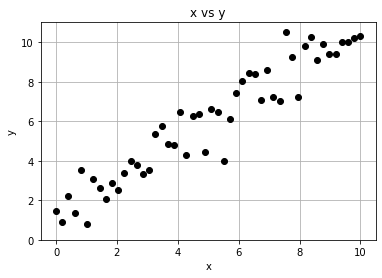

In [3]:
# Matplotlib may give some font errors when loading for the first time, you can ignore these
plt.plot(sim_data['x'], sim_data['y'], 'ko')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('x vs y')
plt.ylim(0,11)

### Resample Points (Parametric Bootstrap)

The first type of bootstrapping we will perform is resampling points.

In [4]:
def resample_regression(df, n_boots, n_params=2, formula='y ~ x'):
    ## array to hold the bootstrap samples of the parameters
    boot_samples = np.zeros((n_boots,n_params))
    n_samples = df.shape[0]
    ## Loop over the number of resamples
    for i in range(n_boots):
        ## Create a bootstrap sample of the data frame
        boot_sample = df.sample(n=n_samples, replace = True)
        ## Compute the OLS model
        boot_model = sm.ols(formula=formula, data=boot_sample).fit()
        ## Save the model parameters in the array
        boot_samples[i,:] = boot_model._results.params
    return boot_samples

param_boots = resample_regression(sim_data,1000)
param_boots[:5]

array([[1.13290799, 0.98560489],
       [1.34751537, 0.93057827],
       [1.36160617, 0.94383043],
       [1.1759036 , 0.99644286],
       [1.16683758, 0.99379272]])

You can see the first few bootstrap estimates of the intercept and slope coefficients.     

Let's look at the distributions of the slope and intercepts. Execute the code in the cell below to examine the distribution of the intercept, along with the confidence intervals. 

> **Note:** The computation of the confidence intervals is an example of a nonparametric bootstrap model. No distributional model is used for residuals. 

Mean =   1.30
Upper confidence interval =   2.00
Lower confidence interval =   0.56


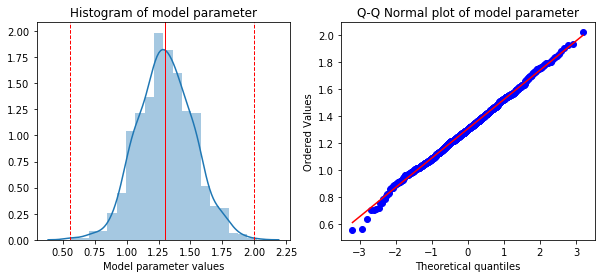

In [5]:
def compute_CI(values, p=0.05):   
    mean = np.mean(values)
    UCI = np.percentile(values, 100-p/2.)
    LCI = np.percentile(values, p/2.)
    print('Mean = %6.2f' % (mean))
    print('Upper confidence interval = %6.2f' % (UCI))
    print('Lower confidence interval = %6.2f' % (LCI))
    return(mean, UCI, LCI)

def plot_boot_params(params):
    mean, UCI, LCI = compute_CI(params)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ## Plot a histogram
    sns.distplot(params, bins=20, ax=ax[0])
    ax[0].axvline(mean, color='red', linewidth=1)
    ax[0].axvline(UCI, color='red', linewidth=1, linestyle='--')
    ax[0].axvline(LCI, color='red', linewidth=1, linestyle='--')
    
    ax[0].set_title('Histogram of model parameter')
    ax[0].set_xlabel('Model parameter values')
    ## Plot the Q-Q Normal plot
    ss.probplot(params, plot = ax[1])
    ax[1].set_title('Q-Q Normal plot of model parameter')
    plt.show()

plot_boot_params(param_boots[:,0])

Next, execute the code in the cell below to display a plot of the slope parameter, along with the confidence intervals. 

Mean =   0.94
Upper confidence interval =   1.09
Lower confidence interval =   0.83


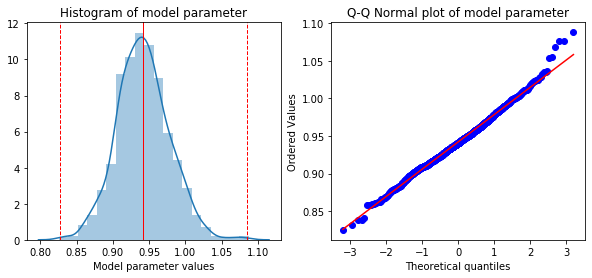

In [6]:
plot_boot_params(param_boots[:,1])

From the plots above you can see the variability and confidence intervals of the parameter estimates. Consider the answers to the following questions:  
1. Are the bootstrap distribution values approximately Normal?
2. Does one coefficient have greater variability than the other, and if so, which one?  
3. Are the known parameter values of the synthetic data within the confidence intervals? 

You can also plot bootstrap realizations of the regression line. This will give you a feel for the variability of the regression solutions. Execute the code in the cell below and examine the result.    

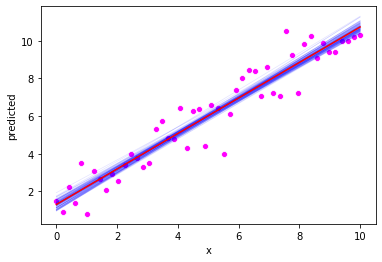

In [7]:
def plot_boot_regression(boot_params, df, n_lines = 100):    
    ## randomly select n_lines to plot
    sample_indx = nr.choice(range(boot_params.shape[0]),n_lines)
    ## Plot the observations
    ax = sns.scatterplot(x='x', y='y', data=df, color = 'magenta')
    ## Loop over the number of bootstrap regression lines to be displayed
    for indx in sample_indx:
        df['predicted'] = boot_params[indx,0] + np.multiply(boot_params[indx,1],df['x'])
        sns.lineplot(x='x', y='predicted', data=df, color='Blue', size = 1.0, alpha=0.1, ax=ax)
    ## Find the mean slope and intercept and plot the line 
    means = np.mean(boot_params, axis=0)
    df['predicted'] = means[0] + np.multiply(means[1],df['x'])
    sns.lineplot(x='x', y='predicted', data=df, color='red', ax=ax)
    ax.get_legend().remove()
    
plot_boot_regression(param_boots, sim_data)    

The plot above shows the following:   
1. The heavy line is the mean parameter regression line.   
2. The light blue lines show a selected number of the bootstrap regression lines. Notice the variability in these possible models. 

**Your Turn:**

You have seen how the bootstrap distribution of the model coefficients gives insight into their variability. But, what about the predicted values. How uncertain are they?

In the cell below use the 1000 bootstrapped values of the slope and intercept to find the distribution of the predicted value, y, for x = 5.0. Compute the mean and CIs and plot the histogram and Q-Q Normal plot. 

Mean =   6.01
Upper confidence interval =   6.40
Lower confidence interval =   5.65


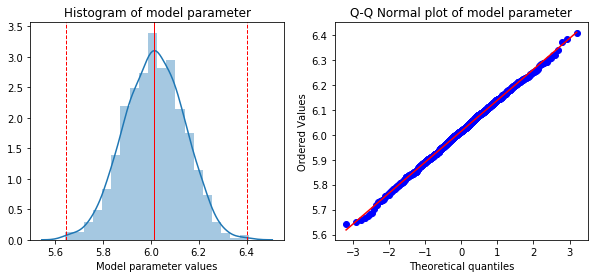

In [13]:
predicted =  np.add(param_boots[:,0], 5.0 * param_boots[:,1])   
plot_boot_params(predicted)

What do the above results tell you about the uncertainty in the predicted values from the regression model? 

#### Copyright 2017, 2018, 2020 Stephen F Elston. All rights reserved.